# RL for LDI Sample Script

Author: Kailan Shang

Date: Dec. 29, 2020

This script is made available for educational purpose, as part of a research project sponsored by the Society of Actuaries.

In [2]:
#Import required packages. You will need to install them before you can run the sript
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing
from torch.autograd import Variable
import torchvision.transforms as T
from collections import namedtuple
import math
import pandas as pd
import numpy as np
import random
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime, date, time

#Import data inputs. Data files are avialable in the Github repository. Once downloaded, the directories listed below may be
#changed to your own directories
MacroFactor = ['gdpgr','pconsump','cpi','Unemploy','m3tb','tb10y','aa10y','gpdinv']
VARModel = 'input/var.csv'
Mapping = 'input/mapping.csv'
Mortality = 'input/mortality.csv'
Census = 'input/census.csv'
RecFun = [77.96,66.31,0.34,-1.23,-25.34,-51.33,-3.4,-9.86,-8.45,-32.19,4.26,0.12,-17.02]
histMF = 'input/histMF.csv' 
histAR = 'input/histAR.csv'
cholMF = 'input/var1chol.csv'
cholNormal = 'input/normalcholf.csv'
cholRecession = 'input/recessioncholf.csv'
termmix = 'input/termmix.csv'
migration = 'input/migration.csv'

#Set the seed of random nunber generation
random.seed(6)

In [3]:
#Check if GPU is available. This script can be run on CPUs but for training process, GPUs are a better choice.
if torch.cuda.is_available():
    print("gpu will be used")
else:
    print("cpu will be used")

cpu will be used


## ESG based on LDI Benchmark Model

The ESG following the rules specified in the LDI Benchmark Model paper: https://www.soa.org/resources/research-reports/2019/liability-driven-investment/

The generation of bond fund returns based on credit rating and rebalancing strategies is time consuming.

Pregenerated scenarios may be used to avoid long run time.

In [4]:
#Define the recession function used in ESG
def recession(fun,vals):
    vals.insert(0,1)
    prob = 1/(1+math.exp(-sum([x*y for x,y in zip(fun, vals)])))
    if prob > 0.5:
        return 1
    else:
        return 0
    
#y = [6.358,0.617,0.921,0.454,6.357,0.680,0.931,0.463,6.349,0.732,0.940,0.471]
#recession(RecFun,y)

In [5]:
#Fully stochastic scenario generation
scale = 1.0 #Scaling of volatilty. If set to 1.0, historical calibration is used.
def sampleMF(var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,dyn,n,stochastic=True):
	var = np.array(var)
	fundmap = np.array(fundmap)
	histMF = np.array(histMF)
	histAR = np.array(histAR)
	cholMF = np.array(cholMF)
	cholNormal = np.array(cholNormal)
	cholRecession = np.array(cholRecession)
	if stochastic==True and dyn>=n:
		sd = var[:,[8]]
		var = var[:,[range(0,9)]]
		hmf = histMF
		hmf3 = np.insert(hmf,0,hmf[hmf.shape[0]-2,:],0)
		recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
		rece = recession(RecFun,recessionVal)
		hmf = hmf[hmf.shape[0]-1,:]
		thmf = np.append(hmf,rece)
		sdtnormal = np.sqrt(fundmap[:,[27]])/scale
		sdtrecession = np.sqrt(fundmap[:,[28]])/scale
		sdinormal = np.sqrt(fundmap[:,[29]])/scale
		sdirecession = fundmap[:,[30]]/scale
		corrnormal = fundmap[:,[31]]
		corrrecession = fundmap[:,[32]]
		fundmap = fundmap[:,[range(0,27)]]
		har = histAR
		har3 = np.insert(har,0,har[har.shape[0]-2,:],0)
		har = har[har.shape[0]-1,:]
		thmf = np.append(thmf,har)
		hmf=np.append(hmf,1)
		for i in range(0,n):
			hmf = var.dot(hmf.T).T
			hmf = hmf + np.multiply(sd.T,np.dot(cholMF,np.array(np.random.normal(0,1,8)).T))
			hmf3[0] = hmf3[1]
			hmf3[1] = hmf3[2]
			hmf3[2] = hmf
			recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
			rece = recession(RecFun,recessionVal)
			for j in range(0,har.shape[0]):
				hartmp = hmf3.flatten('F')
				hartmp = np.insert(hartmp,0,[1,har3[1,j],har3[2,j]])
				har[j] = fundmap[j].dot(hartmp.T).T
			if rece==0:
				rnds = np.multiply(sdinormal.T, np.dot(cholNormal,np.array(np.random.normal(0,1,33)).T))
				rnds = np.multiply((np.multiply(corrnormal.T,har) + np.multiply(np.sqrt(1-np.multiply(corrnormal.T,corrnormal.T)),rnds)),sdinormal.T)
				rnds = np.divide(rnds,np.sqrt(np.multiply(np.multiply(corrnormal.T,corrnormal.T),np.multiply(sdtnormal.T,sdtnormal.T))+np.multiply((1-np.multiply(corrnormal.T,corrnormal.T)),np.multiply(sdinormal.T,sdinormal.T))))
				rnds[0,5]=0 #set random numbers to be zero for those already generated in economic factors.
				rnds[0,8]=0
				rnds[0,10]=0
				rnds[0,30]=0
				rnds[0,31]=0
				har = har + rnds.flatten('F')
			else:
				rnds = np.multiply(sdirecession.T, np.dot(cholRecession,np.array(np.random.normal(0,1,33)).T))
				rnds = np.multiply((np.multiply(corrrecession.T,har) + np.multiply(np.sqrt(1-np.multiply(corrrecession.T,corrrecession.T)),rnds)),sdirecession.T)
				rnds = np.divide(rnds,np.sqrt(np.multiply(np.multiply(corrrecession.T,corrrecession.T),np.multiply(sdtrecession.T,sdtrecession.T))+np.multiply((1-np.multiply(corrrecession.T,corrrecession.T)),np.multiply(sdirecession.T,sdirecession.T))))
				rnds[0,5]=0
				rnds[0,8]=0
				rnds[0,10]=0
				rnds[0,30]=0
				rnds[0,31]=0
				har = har + rnds.flatten('F')
			for ix in range(0,8):
				har[ix]=max(0.1,har[ix])
			for ix in [10,12,14,16]:
				har[ix]=max(0,har[ix])
			for ix in range(0,har.shape[0]):
				har[ix]=max(-99,har[ix])
			har3[0] = har3[1]
			har3[1] = har3[2]
			har3[2] = har
			thmf = np.vstack([thmf, np.append(np.append(hmf,rece),har.flatten())])
			hmf=np.append(hmf,1)
		return thmf
	elif stochastic==True and dyn>0 and dyn<n:
		sd = var[:,[8]]
		var = var[:,[range(0,9)]]
		hmf = histMF
		hmf3 = np.insert(hmf,0,hmf[hmf.shape[0]-2,:],0)
		recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
		rece = recession(RecFun,recessionVal)
		hmf = hmf[hmf.shape[0]-1,:]
		thmf = np.append(hmf,rece)
		sdtnormal = fundmap[:,[27]]/scale
		sdtrecession = fundmap[:,[28]]/scale
		sdinormal = fundmap[:,[29]]/scale
		sdirecession = fundmap[:,[30]]/scale
		corrnormal = fundmap[:,[31]]
		corrrecession = fundmap[:,[32]]
		fundmap = fundmap[:,[range(0,27)]]
		har = histAR
		har3 = np.insert(har,0,har[har.shape[0]-2,:],0)
		har = har[har.shape[0]-1,:]
		thmf = np.append(thmf,har)
		hmf=np.append(hmf,1)
		for i in range(0,dyn):
			hmf = var.dot(hmf.T).T
			hmf = hmf + np.multiply(sd.T,np.dot(cholMF,np.array(np.random.normal(0,1,8)).T))
			hmf3[0] = hmf3[1]
			hmf3[1] = hmf3[2]
			hmf3[2] = hmf
			recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
			rece = recession(RecFun,recessionVal)
			for j in range(0,har.shape[0]):
				hartmp = hmf3.flatten('F')
				hartmp = np.insert(hartmp,0,[1,har3[1,j],har3[2,j]])
				har[j] = fundmap[j].dot(hartmp.T).T
			if rece==0:
				rnds = np.multiply(sdinormal.T, np.dot(cholNormal,np.array(np.random.normal(0,1,33)).T))
				rnds = np.multiply((np.multiply(corrnormal.T,har) + np.multiply(np.sqrt(1-np.multiply(corrnormal.T,corrnormal.T)),rnds)),sdinormal.T)
				rnds = np.divide(rnds,np.sqrt(np.multiply(np.multiply(corrnormal.T,corrnormal.T),np.multiply(sdtnormal.T,sdtnormal.T))+np.multiply((1-np.multiply(corrnormal.T,corrnormal.T)),np.multiply(sdinormal.T,sdinormal.T))))
				rnds[0,5]=0
				rnds[0,8]=0
				rnds[0,10]=0
				rnds[0,30]=0
				rnds[0,31]=0
				har = har + rnds.flatten('F')
			else:
				rnds = np.multiply(sdirecession.T, np.dot(cholRecession,np.array(np.random.normal(0,1,33)).T))
				rnds = np.multiply((np.multiply(corrrecession.T,har) + np.multiply(np.sqrt(1-np.multiply(corrrecession.T,corrrecession.T)),rnds)),sdirecession.T)
				rnds = np.divide(rnds,np.sqrt(np.multiply(np.multiply(corrrecession.T,corrrecession.T),np.multiply(sdtrecession.T,sdtrecession.T))+np.multiply((1-np.multiply(corrrecession.T,corrrecession.T)),np.multiply(sdirecession.T,sdirecession.T))))
				rnds[0,5]=0
				rnds[0,8]=0
				rnds[0,10]=0
				rnds[0,30]=0
				rnds[0,31]=0
				har = har + rnds.flatten('F')
			for ix in range(0,8):
				har[ix]=max(0.1,har[ix])
			for ix in [10,12,14,16]:
				har[ix]=max(0,har[ix])
			for ix in range(0,har.shape[0]):
				har[ix]=max(-99,har[ix])
			har3[0] = har3[1]
			har3[1] = har3[2]
			har3[2] = har
			thmf = np.vstack([thmf, np.append(np.append(hmf,rece),har.flatten())])
			hmf=np.append(hmf,1)
		for i in range(dyn,n):
			hmf = var.dot(hmf.T).T
			hmf3[0] = hmf3[1]
			hmf3[1] = hmf3[2]
			hmf3[2] = hmf
			recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
			rece = recession(RecFun,recessionVal)
			for j in range(0,har.shape[0]):
				hartmp = hmf3.flatten('F')
				hartmp = np.insert(hartmp,0,[1,har3[1,j],har3[2,j]])
				har[j] = fundmap[j].dot(hartmp.T).T
			for ix in range(0,8):
				har[ix]=max(0.1,har[ix])
			for ix in [10,12,14,16]:
				har[ix]=max(0,har[ix])
			for ix in range(0,har.shape[0]):
				har[ix]=max(-99,har[ix])
			har3[0] = har3[1]
			har3[1] = har3[2]
			har3[2] = har
			thmf = np.vstack([thmf, np.append(np.append(hmf,rece),har.flatten())])
			hmf=np.append(hmf,1)
		return thmf
	else:
		var = var[:,[range(0,9)]]
		hmf = histMF
		hmf3 = np.insert(hmf,0,hmf[hmf.shape[0]-2,:],0)
		recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
		rece = recession(RecFun,recessionVal)
		hmf = hmf[hmf.shape[0]-1,:]
		thmf = np.append(hmf,rece)
		sdtnormal = fundmap[:,[27]]/scale
		sdtrecession = fundmap[:,[28]]/scale
		sdinormal = fundmap[:,[29]]/scale
		sdirecession = fundmap[:,[30]]/scale
		corrnormal = fundmap[:,[31]]
		corrrecession = fundmap[:,[32]]
		fundmap = fundmap[:,[range(0,27)]]
		har = histAR
		har3 = np.insert(har,0,har[har.shape[0]-2,:],0)
		har = har[har.shape[0]-1,:]
		thmf = np.append(thmf,har)
		hmf=np.append(hmf,1)
		for i in range(0,n):
			hmf = var.dot(hmf.T).T
			hmf3[0] = hmf3[1]
			hmf3[1] = hmf3[2]
			hmf3[2] = hmf
			recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
			rece = recession(RecFun,recessionVal)
			for j in range(0,har.shape[0]):
				hartmp = hmf3.flatten('F')
				hartmp = np.insert(hartmp,0,[1,har3[1,j],har3[2,j]])
				har[j] = fundmap[j].dot(hartmp.T).T
			for ix in range(0,8):
				har[ix]=max(0.1,har[ix])
			for ix in [10,12,14,16]:
				har[ix]=max(0,har[ix])
			for ix in range(0,har.shape[0]):
				har[ix]=max(-99,har[ix])
			har3[0] = har3[1]
			har3[1] = har3[2]
			har3[2] = har
			thmf = np.vstack([thmf, np.append(np.append(hmf,rece),har.flatten())])
			hmf=np.append(hmf,1)
		return thmf

var = pd.read_csv(VARModel)
hmf = pd.read_csv(histMF)
var1chol = pd.read_csv(cholMF)
fundmap = pd.read_csv(Mapping)
har = pd.read_csv(histAR)
normalChol = pd.read_csv(cholNormal)
recessionChol = pd.read_csv(cholRecession)
thmf=sampleMF(var,fundmap,hmf,har,var1chol,normalChol,recessionChol,5,30,stochastic=True)
np.corrcoef(thmf[:,[18,20,22,24]],rowvar=False)

# check = sampleMF(var,fundmap,hmf,har,var1chol,normalChol,recessionChol,60,60,stochastic=False)
# check[60]

/var/folders/8q/9zk58sl93rx81t6np6mvjx200000gn/T/ipykernel_18910/1927977030.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  har[j] = fundmap[j].dot(hartmp.T).T
/var/folders/8q/9zk58sl93rx81t6np6mvjx200000gn/T/ipykernel_18910/1927977030.py:112: RuntimeWarning: invalid value encountered in divide
  rnds = np.divide(rnds,np.sqrt(np.multiply(np.multiply(corrnormal.T,corrnormal.T),np.multiply(sdtnormal.T,sdtnormal.T))+np.multiply((1-np.multiply(corrnormal.T,corrnormal.T)),np.multiply(sdinormal.T,sdinormal.T))))
/var/folders/8q/9zk58sl93rx81t6np6mvjx200000gn/T/ipykernel_18910/1927977030.py:122: RuntimeWarning: invalid value encountered in divide
  rnds = np.divide(rnds,np.sqrt(np.multiply(np.multiply(corrrecession.T,corrrecession.T),np.multiply(sdtrecession.T,sdtrecession.T))+np.multiply((1-np.multiply(corrreces

array([[1.        , 0.82851071, 0.72024041, 0.66967534],
       [0.82851071, 1.        , 0.96351761, 0.95786333],
       [0.72024041, 0.96351761, 1.        , 0.99031253],
       [0.66967534, 0.95786333, 0.99031253, 1.        ]])

In [6]:
# for period after n, genearte expected scenarios instead of stochastic scenarios
def sampleMF2(thmf,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,dyn,n):
	var = np.array(var)
	fundmap = np.array(fundmap)
	histMF = np.array(histMF)
	histAR = np.array(histAR)
	cholMF = np.array(cholMF)
	cholNormal = np.array(cholNormal)
	cholRecession = np.array(cholRecession)

	sd = var[:,[8]]
	var = var[:,[range(0,9)]]
	hmf = histMF
	hmf3 = np.insert(hmf,0,hmf[hmf.shape[0]-2,:],0)
	recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
	rece = recession(RecFun,recessionVal)
	hmf = hmf[hmf.shape[0]-1,:]
	sdtnormal = fundmap[:,[27]]/scale
	sdtrecession = fundmap[:,[28]]/scale
	sdinormal = fundmap[:,[29]]/scale
	sdirecession = fundmap[:,[30]]/scale
	corrnormal = fundmap[:,[31]]
	corrrecession = fundmap[:,[32]]
	fundmap = fundmap[:,[range(0,27)]]
	har = histAR
	har3 = np.insert(har,0,har[har.shape[0]-2,:],0)
	har = har[har.shape[0]-1,:]
	hmf=np.append(hmf,1)

	thmf = thmf[range(0,dyn+1),:]
	har = thmf[dyn,range(9,42)]
	hmf = thmf[dyn,range(0,8)]

	if dyn==1:
		har3[0]=har3[1]
		har3[1]=har3[2]
		har3[2]=har
		hmf3[0] = hmf3[1]
		hmf3[1] = hmf3[2]
		hmf3[2] = hmf
	elif dyn==2:
		har3[0]=har3[2]
		har3[1]=thmf[dyn-1,range(9,42)]
		har3[2]=har
		hmf3[0] = hmf3[2]
		hmf3[1] = thmf[dyn-1,range(0,8)]
		hmf3[2] = hmf
	elif dyn>2:
		har3[0]=thmf[dyn-2,range(9,42)]
		har3[1]=thmf[dyn-1,range(9,42)]
		har3[2]=har
		hmf3[0] = thmf[dyn-2,range(0,8)]
		hmf3[1] = thmf[dyn-1,range(0,8)]
		hmf3[2] = hmf
		
	hmf=np.append(hmf,1)
	
	for i in range(dyn,n):
		hmf = var.dot(hmf.T).T
		hmf3[0] = hmf3[1]
		hmf3[1] = hmf3[2]
		hmf3[2] = hmf
		recessionVal = [hmf3[2,3],hmf3[2,7],hmf3[2,1],hmf3[2,0],hmf3[1,3],hmf3[1,7],hmf3[1,1],hmf3[1,0],hmf3[0,3],hmf3[0,7],hmf3[0,1],hmf3[0,0]]
		rece = recession(RecFun,recessionVal)
		for j in range(0,har.shape[0]):
			hartmp = hmf3.flatten('F')
			hartmp = np.insert(hartmp,0,[1,har3[1,j],har3[2,j]])
			har[j] = fundmap[j].dot(hartmp.T).T
		for ix in range(0,8):
			har[ix]=max(0.1,har[ix])
		for ix in [10,12,14,16]:
			har[ix]=max(0,har[ix])
		for ix in range(0,har.shape[0]):
			har[ix]=max(-99,har[ix])
		har3[0] = har3[1]
		har3[1] = har3[2]
		har3[2] = har
		thmf = np.vstack([thmf, np.append(np.append(hmf,rece),har.flatten())])
		hmf=np.append(hmf,1)
	return thmf

# sampleMF2(thmf, var,fundmap,hmf,har,var1chol,normalChol,recessionChol,5,30)[6]

In [7]:
from scipy.interpolate import interp1d
x = np.array([1,2,3,5,7,10,20])
y = np.array([0.5,1.1,1.2,1.9,2.15,2.5,3])
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

In [8]:
#xnew = np.linspace(1, 20, num=41, endpoint=True)
#import matplotlib.pyplot as plt
#plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
#plt.legend(['data', 'linear', 'cubic'], loc='best')
#plt.show()

In [9]:
def curvefitting(value,term=np.array([0.25,1,2,3,5,7,10,20,30]),inter="linear",extro="cfr",target=0.04):
	if value.shape[0] != term.shape[0]:
		return -1
	else:
		startT = term[0]
		endT = term[term.shape[0]-1]
		secondEndT = term[term.shape[0]-2]
		xnew = np.linspace(startT,endT,num=int(round((endT-startT)*4+1)),endpoint=True)
		if inter=="linear":
			f = interp1d(term, value)
		else:
			f = interp1d(term, value, kind='cubic')
		ynew = f(xnew)
		if endT < 100:
			xnew2 = np.linspace(endT+0.25,100,num=int(round((100-endT)*4)),endpoint=True)
			ynew2=[]
			if extro=="cfr":
				cfr = (((1+value[value.shape[0]-1]) ** endT)/((1+value[value.shape[0]-2]) ** secondEndT)) ** (1/(endT-secondEndT))-1
				cumfac = (1+value[value.shape[0]-1]) ** endT
				for ix in xnew2:
					cumfac = cumfac*(1+cfr)**(1/4)
					ynew2.append(cumfac**(1/ix)-1)
			else:
				p = np.poly1d(np.polyfit(np.array([secondEndT,endT,100]),np.array([value[value.shape[0]-2],value[value.shape[0]-1],target]),deg=2))
				ynew2 = p(xnew2)
		x = np.append(xnew,xnew2)
		y = np.append(ynew,ynew2)
		return x,y

# xi,yi = curvefitting(np.array([0.25,0.3,0.5,1.1,1.2,1.9,2.15,2.5,3])/100,inter="linear",extro="tar")
# term = np.array([0.25,1,2,3,5,7,10,20,30])
# value = np.array([0.25,0.3,0.5,1.1,1.2,1.9,2.15,2.5,3])/100
# plt.plot(term, value, 'o', xi, yi, '-')
# plt.legend(['data', 'linear'], loc='best')
# plt.show()

In [10]:
#Bond pricer
def bondPrice(terms,rates,term,freq,coupon,redemption,inter="linear",extro="tar",expectedRate=0.04):
	xi,yi = curvefitting(rates,terms,inter=inter,extro=extro,target=expectedRate)
	f = interp1d(xi,yi)
	if term > 0.25:
		bondvalue = redemption*(1+coupon*freq)/(1+f(term))**term
	else:
		bondvalue = redemption
	for i in np.arange(term-freq,0.01,-freq):
		bondvalue = bondvalue + redemption*coupon*freq/(1+f(i))**(i)
	return bondvalue
term = np.array([0.25,1,2,3,5,7,10,20,30])
value = np.array([0.575593169+0.457631,0.842160583+0.457631,1.20,1.47,1.93,2.25,2.45,2.79,3.06])/100
bondPrice(term,value,0.75,1,1.14/100,21705)

np.float64(21755.153866790886)

In [11]:
#Bond fund return calculator for each credit rating with a target duration and rebalancing strategy
def bondReturn(thmf,mix,migrationM,dyn=10,n=10,rating=2,rebalance=0.5,bondfreq=0.25,inter="linear",extro="tar",expectedRate=0.04):
#rating: 0-Govt Bond; 1-AAA; 2-AA; 3-A; 4-BBB
	term = np.array([0.25,1,2,3,5,7,10,20,30])
	initialVal = 1000000
	migrationM = np.array(migrationM)/100
	recoveryM = migrationM[:,6]*100
	mix = np.array(mix)
	#rating=2
	#bondfreq=0.25
	MVM = mix[rating] * initialVal
	value = thmf[0,[4,9,10,11,12,13,14,15,16]]
	if rating>0:
		value = value + thmf[0,16+rating*2]
	default= np.append(0,thmf[0,[19,21,23,25]])/100
	xnew = np.linspace(0.25,30,num=120,endpoint=True)
	inter="linear"
	if inter=="linear":
		f = interp1d(term,value)
	else:
		f = interp1d(term,value,kind='cubic')
	CouponM = np.array(f(xnew))
	FVM = np.copy(MVM)
	for i in range(0,120):
		FVM[i] = FVM[i]/bondPrice(term,value/100,(i+1)*0.25,bondfreq,CouponM[i]/100,1,inter=inter,extro=extro,expectedRate=expectedRate)
	nBSM = np.repeat(0.0,120)
	RedemptionM = np.repeat(0.0,120)
	tMVM = np.copy(MVM)
	tFVM = np.copy(FVM)
	tBSM = np.copy(nBSM)
	tRDM = np.copy(RedemptionM)
	tCRM = np.copy(CouponM)
	cashRtn = []
	priceRtn = []

	for i in range(1,thmf.shape[0]):
		bcurve = thmf[i,[4,9,10,11,12,13,14,15,16]]
		bcurve = np.vstack([bcurve,bcurve + thmf[i,18]])
		bcurve = np.vstack([bcurve,bcurve[0] + thmf[i,20]])
		bcurve = np.vstack([bcurve,bcurve[0] + thmf[i,22]])
		bcurve = np.vstack([bcurve,bcurve[0] + thmf[i,24]])
		bcurve = np.vstack([bcurve,bcurve[4] + 2.499197])
		#if i==1:
			#print bcurve
		nMVM = np.repeat(0.0,120)
		nFVM = np.repeat(0.0,120)
		nBSM = np.repeat(0.0,120)
		RedemptionM = np.repeat(0.0,120)

		totalBS = 0.0
		xnew = np.linspace(0.25,30,num=120,endpoint=True)
		inter="linear"
		if inter=="linear":
			f = interp1d(term,bcurve[rating])
		else:
			f = interp1d(term,bcurve[rating],kind='cubic')
		nCouponM = np.array(f(xnew))
		for j in range(0,120):
			for k in range(0,6):
				if k==rating:
					nMVM[j] = bondPrice(term,bcurve[rating]/100,(j+1)/4.0-0.25,bondfreq,CouponM[j]/100,FVM[j],inter=inter,extro=extro,expectedRate=expectedRate)*migrationM[rating,rating]*(1-default[rating]*(1-recoveryM[rating]))
					nFVM[j] = FVM[j]*migrationM[rating,rating]*(1-default[rating]*(1-recoveryM[rating]))
				else:
					totalBS = totalBS + bondPrice(term,bcurve[k]/100,(j+1)/4.0-0.25,bondfreq,CouponM[j]/100,FVM[j],inter=inter,extro=extro,expectedRate=expectedRate)*migrationM[rating,k]*(1-default[rating]*(1-recoveryM[rating]))
			if j==0:
				RedemptionM[j] = nMVM[j]*(1-default[rating]*(1-recoveryM[rating]))
			if ((j+1)%int(bondfreq*4)==1 and bondfreq>0.25) or bondfreq==0.25:
				RedemptionM[j] = RedemptionM[j] + FVM[j]*CouponM[j]/100*bondfreq*(1-default[rating]*(1-recoveryM[rating]))
	
		totalBS = totalBS + np.sum(RedemptionM)
		if rebalance==0:
			nBSM=totalBS*mix[rating]
			nBSFM = np.repeat(0.0,120)
			for j in range(0,120):
				nBSFM[j] = nBSM[j]/bondPrice(term,bcurve[rating]/100,(j+1)/4.0,bondfreq,nCouponM[j]/100,1)
			for j in range(1,120):
				MVM[j-1]=nMVM[j]
				FVM[j-1]=nFVM[j]
			MVM[119]=0
			FVM[119]=0
			for j in range(1,120):
				if (FVM[j-1]+nBSFM[j-1]) != 0:
					CouponM[j-1]=(FVM[j-1]*CouponM[j]+nBSFM[j-1]*nCouponM[j-1])/(FVM[j-1]+nBSFM[j-1])
				else:
					CouponM[j-1]=CouponM[j]
			CouponM[119]=nCouponM[119]
			MVM = MVM + nBSM
			FVM = FVM + nBSFM
		elif i%int(rebalance*4)==0:
			totalBS = totalBS + np.sum(nMVM)
			nBSM=totalBS*mix[rating]
			for j in range(0,119):
				nBSM[j] = nBSM[j]-nMVM[j+1]
			nBSFM = np.repeat(0.0,120)
			for j in range(0,120):
				if nBSM[j]<0:
					nBSFM[j] = nBSM[j]/bondPrice(term,bcurve[rating]/100,(j+1)/4.0,bondfreq,CouponM[j+1]/100,1,inter=inter,extro=extro,expectedRate=expectedRate)
				else:
					nBSFM[j] = nBSM[j]/bondPrice(term,bcurve[rating]/100,(j+1)/4.0,bondfreq,nCouponM[j]/100,1,inter=inter,extro=extro,expectedRate=expectedRate)				
			for j in range(1,120):
				MVM[j-1]=nMVM[j]
				FVM[j-1]=nFVM[j]
			MVM[119]=0
			FVM[119]=0
			for j in range(1,120):
				if nBSM[j-1]>0 and (FVM[j-1]+nBSFM[j-1])!=0:
					CouponM[j-1]=(FVM[j-1]*CouponM[j]+nBSFM[j-1]*nCouponM[j-1])/(FVM[j-1]+nBSFM[j-1])
				else:
					CouponM[j-1]=CouponM[j]
			CouponM[119]=nCouponM[119]
			MVM = MVM + nBSM
			FVM = FVM + nBSFM
		else:
			nBSM=totalBS*mix[rating]
			nBSFM = np.repeat(0.0,120)
			for j in range(0,120):
				nBSFM[j] = nBSM[j]/bondPrice(term,value/100,(j+1)/4,bondfreq,nCouponM[j]/100,1,inter=inter,extro=extro,expectedRate=expectedRate)
			for j in range(1,120):
				MVM[j-1]=nMVM[j]
				FVM[j-1]=nFVM[j]
			MVM[119]=0
			FVM[119]=0
			for j in range(1,120):
				if (FVM[j-1]+nBSFM[j-1]) != 0:
					CouponM[j-1]=(FVM[j-1]*CouponM[j]+nBSFM[j-1]*nCouponM[j-1])/(FVM[j-1]+nBSFM[j-1])
				else:
					CouponM[j-1]=CouponM[j]
			CouponM[119]=nCouponM[119]
			MVM = MVM + nBSM
			FVM = FVM + nBSFM
		tMVM = np.vstack([tMVM,MVM])
		tFVM = np.vstack([tFVM,FVM])
		tBSM = np.vstack([tBSM,nBSM])
		tRDM = np.vstack([tRDM,RedemptionM])
		tCRM = np.vstack([tCRM,CouponM])
		cashRtn = np.append(cashRtn,np.sum(RedemptionM)/initialVal)
		priceRtn = np.append(priceRtn,(np.sum(MVM)-np.sum(RedemptionM))/initialVal-1)
		default= np.append(0,thmf[i,[19,21,23,25]])/100
		initialVal = np.sum(MVM)
	return cashRtn,priceRtn


# migrationM = pd.read_csv(migration)
# mix=pd.read_csv(termmix)
# cashR,priceR = bondReturn(check,mix,migrationM,dyn=60,n=60,rating=4,rebalance=1,bondfreq=1,inter="linear",extro="cfr",expectedRate=0.04)
# priceR

In [12]:
#Add bond fund returns to the stochastic scenarios
def AddBondReturn(thmf,mix,migrationM,dyn=10,n=10,rebalance=0,bondfreq=0.25,inter="linear",extro="tar",expectedRate=0.04):
	for ir in range(0,5):
		cashR,priceR = bondReturn(thmf=thmf,mix=mix,migrationM=migrationM,dyn=10,n=n,rating=ir,rebalance=rebalance,bondfreq=bondfreq,inter=inter,extro=extro,expectedRate=expectedRate)
		thmf = np.append(thmf,np.transpose(np.vstack([np.insert(cashR,0,0),np.insert(priceR,0,0)])),axis=1)
		#print "rating ", ir, " done"
	return thmf

In [13]:
#Adjust bond fund returns for periods after dynamic projection time to approximate expected bond fund returns
def AdjustBondReturn(thmf,thmfBase,thmfFull,dyn=10,n=10):
	thmf = np.append(thmf,thmfBase[:,range(42,52)],axis=1)
	for i in range(0,n):
		if i> dyn:
			for ir in [43,45,47,49,51]:
				thmf[i,ir] = thmfBase[i,ir]+(thmfBase[i,14]-thmfFull[i,14])/400
			for ir in [45,47,49,51]:
				thmf[i,ir] = thmfBase[i,ir]+(thmfFull[i,ir-27]-thmfBase[i,ir-27] - thmfFull[i,ir-26]+thmfBase[i,ir-26])/400
	return thmf

## Dynamic Pension Plan Projection

Together with ESG, dynamic projection of asset, liabilty and funding status is performed based on the LDI benchmark model.

Dynamic liability projection is computational intensive. All assumptions follow the research report.

In [14]:
#Dynamic liability projection assumptions (consistent with research paper)
fMI = 0.01 #female mortality improvement
mMI = 0.01 #male mortality improvement
salaryGr = 0.02 #salary growth rate
salaryAvgPeriod = 5 #salary averaging period
benefitRate = 0.01 #benefit rate as percentage of averaging salary
COLA = 0.8 #portion of cost of living adjustment based on CPI
maxCOLA = 0.05 #maximum annual COLA rate
lumpSumProb = 0.1 #probabiilty that the benefits are paid as a lump sum
lumpSumDR = 0.04 #discount rate used to calculate lump sum
valuationDate = date(2016,12,31) #valuation date
planliab = 10000000. #initial plan liability

#Sample plan participant information
#All plan particpant information is stored in file Census
dateOfBirth = date(1981,6,30) #date of birth for a sample plan participant
startDate = date(2005,1,31) #start date of employment
salary = 80000. #current salary
retireDate = date(2045,6,30) #expected retirement date
weight = 0.08 #weight of the sample plan participant as in the entire pension plan
occupation = 4 #occupation type
salaryMultiple = np.array([0.9,1.0,1.1,1.2,1.5]) #salary multiple for each occupation type
gender = "F" #gender of the sample plan participant


dyn=10 #dynamic projection time point in quarter
inter="linear" #yield curve interpolation method
extro="tar" #yield curve extrapolation method
target=0.04 #target long term interest rate

In [15]:
#Calculate projected benefit obligation for individual plan participant
def pbo(gender,dateOfBirth, startDate,retireDate,salary,occupation,weight,thmf,dyn,inter="linear",extro="tar",target=0.04):
	wTerms = int(max(0,(retireDate.year - valuationDate.year)*4+(retireDate.month-valuationDate.month)/4))+1
	retireArray = np.repeat(0,wTerms)
	retireArray = np.append(retireArray,np.repeat(1,361-wTerms))
	servicePeriod = (valuationDate.year - startDate.year) + (valuationDate.month - startDate.month)/12.
	spArray = np.repeat(servicePeriod,361)
	age = (valuationDate.year - dateOfBirth.year) + (valuationDate.month - startDate.month)/12.
	ageArray = np.repeat(age,361)
	qScn = thmf.shape[0]-1
	wageIndex = np.repeat(1.,361)
	COLAArray = np.repeat(1.,361)
	salaryArray = np.repeat(salary,361)
	supSalaryArray = np.repeat(salary,361+salaryAvgPeriod*4-1)
	for i in range(0,salaryAvgPeriod*4-1):
		if i%4 == 0:
			supSalaryArray[i] = salary/(1+salaryGr*salaryMultiple[occupation-1])**(salaryAvgPeriod-1-i/4)
		else:
			supSalaryArray[i] = supSalaryArray[i-1]
	avgSalaryArray = np.repeat(np.average(supSalaryArray[0:salaryAvgPeriod*4]),361)
	accBenefitArray = np.repeat(0.,361)
	prjBenefitArray = np.repeat(0.,361)
	paymentArray = np.repeat(0.,361)
	prjPaymentArray = np.repeat(0.,361)

	mortTables = pd.read_csv(Mortality)
	mortTables = np.array(mortTables)
	if gender == "M":
		baseMortArray = np.repeat(1-(1-mortTables[min(110,int(round(age))),1])**0.25,361)
	else:
		baseMortArray = np.repeat(1-(1-mortTables[min(110,int(round(age))),2])**0.25,361)

	survivorship = np.repeat(1.,361)

	ldrArray = np.repeat(1.,361)
	pcdrArray = np.repeat(1.,361)
	lsdrArray = np.repeat(1.,361)

	value = thmf[dyn,[4,9,10,11,12,13,14,15,16]]
	value = value + thmf[dyn,20]
	xi,yi = curvefitting(value/100,term=np.array([0.25,1,2,3,5,7,10,20,30]),inter=inter,extro=extro,target=target)

	for t in range(1,361):

		if retireArray[t] == 1:
			spArray[t] = spArray[t-1]
		else:
			spArray[t] = servicePeriod + t/4.

		ageArray[t] = age + t/4.

		if retireArray[t] == 1:
			wageIndex[t] = wageIndex[t-1]
		elif t%4 == 0:
			wageIndex[t] = wageIndex[t-1]*(1+((1+thmf[min(t,qScn),38]/100)*(1+thmf[min(t-1,qScn),38]/100)*(1+thmf[min(t-2,qScn),38]/100)*(1+thmf[min(t-3,qScn),38]/100)-1)*salaryMultiple[occupation-1])
		else:
			wageIndex[t] = wageIndex[t-1]

		if retireArray[t] == 0:
			COLAArray[t] = 1
		elif t%4 == 0:
			COLAArray[t] = COLAArray[t-1] * min(1+maxCOLA,(1-COLA)+COLA*(1+thmf[min(t,qScn),17]/100)*(1+thmf[min(t-1,qScn),17]/100)*(1+thmf[min(t-2,qScn),17]/100)*(1+thmf[min(t-3,qScn),17]/100))
		else:
			COLAArray[t] = COLAArray[t-1]

		if retireArray[t] == 0:
			salaryArray[t] = salary * wageIndex[t]
			supSalaryArray[t+salaryAvgPeriod*4-1] = salaryArray[t]
		else:
			salaryArray[t] = salaryArray[t-1]
			supSalaryArray[t+salaryAvgPeriod*4-1] = salaryArray[t]

		avgSalaryArray[t] = np.average(supSalaryArray[t:(t+salaryAvgPeriod*4)])

		accBenefitArray[t] = avgSalaryArray[t]*benefitRate*min(servicePeriod+dyn/4.,spArray[t])*COLAArray[t]/4
		prjBenefitArray[t] = avgSalaryArray[t]*benefitRate*spArray[t]*COLAArray[t]/4

		if gender == "M":
			baseMortArray[t] = 1-(1-mortTables[min(110,int(round(ageArray[t]))),1])**0.25
			survivorship[t] = survivorship[t-1]*(1-baseMortArray[t]*(1-mMI))
		else:
			baseMortArray[t] = 1-(1-mortTables[min(110,int(round(ageArray[t]))),2])**0.25
			survivorship[t] = survivorship[t-1]*(1-baseMortArray[t]*(1-fMI))

		lsdrArray[t] = lsdrArray[t-1]/(1+lumpSumDR)**0.25
		mt = thmf.shape[0]-1
		if t <dyn:
			ldrArray[t] = 1
			pcdrArray[t] = 1
		else:
			ldrArray[t] = ldrArray[t-1]/(1+yi[t-dyn])**0.25

	lumpSum = np.sum(np.multiply(np.multiply(np.multiply(lsdrArray,accBenefitArray),survivorship),retireArray))/lsdrArray[wTerms]/survivorship[wTerms]
	for t in range(1,361):
		if wTerms == 0:
			paymentArray[t] = accBenefitArray[t]*retireArray[t]*survivorship[t]
			prjPaymentArray[t] = prjBenefitArray[t]*retireArray[t]*survivorship[t]
		elif t == wTerms:
			paymentArray[t] = accBenefitArray[t]*retireArray[t]*survivorship[t]*(1-lumpSumProb)+lumpSum*lumpSumProb
			prjPaymentArray[t] = prjBenefitArray[t]*retireArray[t]*survivorship[t]
		else:
			paymentArray[t] = accBenefitArray[t]*retireArray[t]*survivorship[t]*(1-lumpSumProb)
			prjPaymentArray[t] = prjBenefitArray[t]*retireArray[t]*survivorship[t]
	dynArray = np.repeat(0,361)
	for t in range(0,361):
		if t > dyn:
			dynArray[t]=1

	dynPBO = np.sum(np.multiply(np.multiply(paymentArray,ldrArray),dynArray))/survivorship[dyn]
	if retireArray[dyn]==0:
		planCost = 0.25/max(spArray)*np.sum(np.multiply(prjPaymentArray,pcdrArray))/survivorship[dyn]
	else:
		planCost = 0
	return [dynPBO,planCost,paymentArray[dyn],prjPaymentArray[dyn]]

In [16]:
employees = pd.read_csv(Census)

#Calculate initial liabilty multiple to match initial plan liability
def liabMultiple(employees,thmf,planliab=10000000.,inter="linear",extro="tar",target=0.04):
	liabSum = 0
	employees = np.array(employees)
	for employID in range(0,employees.shape[0]):
		gender=employees[employID,2]
		dateOfBirth=date(*map(int, employees[employID,3].split('-')))
		startDate=date(*map(int, employees[employID,4].split('-')))
		retireDate=date(*map(int, employees[employID,6].split('-')))
		salary=employees[employID,5]
		occupation=employees[employID,7]
		weight=employees[employID,8]
		wTerms = int(max(0,(retireDate.year - valuationDate.year)*4+(retireDate.month-valuationDate.month)/4))+1
		retireArray = np.repeat(0,wTerms)
		retireArray = np.append(retireArray,np.repeat(1,361-wTerms))
		servicePeriod = (valuationDate.year - startDate.year) + (valuationDate.month - startDate.month)/12.
		spArray = np.repeat(servicePeriod,361)
		age = (valuationDate.year - dateOfBirth.year) + (valuationDate.month - startDate.month)/12.
		ageArray = np.repeat(age,361)
		qScn = thmf.shape[0]-1
		wageIndex = np.repeat(1.,361)
		COLAArray = np.repeat(1.,361)
		salaryArray = np.repeat(salary,361)
		supSalaryArray = np.repeat(salary,361+salaryAvgPeriod*4-1)
		for i in range(0,salaryAvgPeriod*4-1):
			if i%4 == 0:
				supSalaryArray[i] = salary/(1+salaryGr*salaryMultiple[occupation-1])**(salaryAvgPeriod-1-i/4)
			else:
				supSalaryArray[i] = supSalaryArray[i-1]
		avgSalaryArray = np.repeat(np.average(supSalaryArray[0:salaryAvgPeriod*4]),361)
		accBenefitArray = np.repeat(0.,361)
		paymentArray = np.repeat(0.,361)

		mortTables = pd.read_csv(Mortality)
		mortTables = np.array(mortTables)
		if gender == "M":
			baseMortArray = np.repeat(1-(1-mortTables[min(110,int(round(age))),1])**0.25,361)
		else:
			baseMortArray = np.repeat(1-(1-mortTables[min(110,int(round(age))),2])**0.25,361)

		survivorship = np.repeat(1.,361)

		ldrArray = np.repeat(1.,361)
		lsdrArray = np.repeat(1.,361)

		value = thmf[0,[4,9,10,11,12,13,14,15,16]]
		value = value + thmf[0,20]
		xi,yi = curvefitting(value/100,term=np.array([0.25,1,2,3,5,7,10,20,30]),inter=inter,extro=extro,target=target)

		for t in range(1,361):

			if retireArray[t] == 1:
				spArray[t] = spArray[t-1]
			else:
				spArray[t] = servicePeriod + t/4.

			ageArray[t] = age + t/4.

			if retireArray[t] == 1:
				wageIndex[t] = wageIndex[t-1]
			elif t%4 == 0:
				wageIndex[t] = wageIndex[t-1]*(1+((1+thmf[min(t,qScn),38]/100)*(1+thmf[min(t-1,qScn),38]/100)*(1+thmf[min(t-2,qScn),38]/100)*(1+thmf[min(t-3,qScn),38]/100)-1)*salaryMultiple[occupation-1])
			else:
				wageIndex[t] = wageIndex[t-1]

			if retireArray[t] == 0:
				COLAArray[t] = 1
			elif t%4 == 0:
				COLAArray[t] = COLAArray[t-1] * min(1+maxCOLA,(1-COLA)+COLA*(1+thmf[min(t,qScn),17]/100)*(1+thmf[min(t-1,qScn),17]/100)*(1+thmf[min(t-2,qScn),17]/100)*(1+thmf[min(t-3,qScn),17]/100))
			else:
				COLAArray[t] = COLAArray[t-1]

			if retireArray[t] == 0:
				salaryArray[t] = salary * wageIndex[t]
				supSalaryArray[t+salaryAvgPeriod*4-1] = salaryArray[t]
			else:
				salaryArray[t] = salaryArray[t-1]
				supSalaryArray[t+salaryAvgPeriod*4-1] = salaryArray[t]

			avgSalaryArray[t] = np.average(supSalaryArray[t:(t+salaryAvgPeriod*4)])

			accBenefitArray[t] = avgSalaryArray[t]*benefitRate*servicePeriod*COLAArray[t]/4

			if gender == "M":
				baseMortArray[t] = 1-(1-mortTables[min(110,int(round(ageArray[t]))),1])**0.25
				survivorship[t] = survivorship[t-1]*(1-baseMortArray[t]*(1-mMI))
			else:
				baseMortArray[t] = 1-(1-mortTables[min(110,int(round(ageArray[t]))),2])**0.25
				survivorship[t] = survivorship[t-1]*(1-baseMortArray[t]*(1-fMI))

		
			lsdrArray[t] = lsdrArray[t-1]/(1+lumpSumDR)**0.25
			ldrArray[t] = ldrArray[t-1]/(1+yi[t])**0.25
	
		lumpSum = np.sum(np.multiply(np.multiply(np.multiply(lsdrArray,accBenefitArray),survivorship),retireArray))/lsdrArray[wTerms]/survivorship[wTerms]
		for t in range(1,361):
			if wTerms == 0:
				paymentArray[t] = accBenefitArray[t]*retireArray[t]*survivorship[t]
			elif t == wTerms:
				paymentArray[t] = accBenefitArray[t]*retireArray[t]*survivorship[t]*(1-lumpSumProb)+lumpSum*lumpSumProb
			else:
				paymentArray[t] = accBenefitArray[t]*retireArray[t]*survivorship[t]*(1-lumpSumProb)

		dynPBO = np.sum(np.multiply(paymentArray,ldrArray))
		#if employID==8:
			#print accBenefitArray,paymentArray
		liabSum = liabSum + dynPBO*weight
		#print(dynPBO, weight)
	multiple = planliab/liabSum
	return multiple

check = sampleMF(var,fundmap,hmf,har,var1chol,normalChol,recessionChol,60,60,stochastic=False)
multiple = liabMultiple(employees,check,planliab,inter,extro,target)
print(multiple)

50.230445964671105


/var/folders/8q/9zk58sl93rx81t6np6mvjx200000gn/T/ipykernel_18910/1927977030.py:193: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  har[j] = fundmap[j].dot(hartmp.T).T


In [17]:
#aggregated projected benefit obligation for all plan participants by matching initial plan liability.
def aggPBO(employees,thmf,dyn,multiple,planliab=10000000.,inter="linear",extro="tar",target=0.04):
	aggResult = np.array([0,0,0,0])
	employees = np.array(employees)
	#multiple = liabMultiple(employees,thmf,planliab,inter,extro,target)
#	print multiple
	for employID in range(0,employees.shape[0]):
		gender=employees[employID,2]
		dateOfBirth=date(*map(int, employees[employID,3].split('-')))
		startDate=date(*map(int, employees[employID,4].split('-')))
		retireDate=date(*map(int, employees[employID,6].split('-')))
		salary=employees[employID,5]
		occupation=employees[employID,7]
		weight=employees[employID,8]
#		print weight
		aggResult = aggResult + np.multiply(weight, np.array(pbo(gender,dateOfBirth, startDate,retireDate,salary,occupation,weight,thmf,dyn,inter,extro,target)))
#		print(weight,np.array(pbo(gender,dateOfBirth, startDate,retireDate,salary,occupation,weight,thmf,dyn,inter,extro,target)))
	aggResult = np.multiply(aggResult, multiple)
	return aggResult

In [18]:
#dynamic asset projection assumption
nsim = 1 #number of simulations
ndyn = 60 #numbr of dynamic periods in quarter
max_period = 40 #maximum number of periods for projection
planasset = 10000000.*1.0 #initial plan asset

saa=[0.5,0.5] #sample asset allocation (AA-rated bond, large scale public equity)
rebalance = 0.25
bondfreq = 0.25 #bond coupon frequency in bond fund calculation
expectedRate = 0.04 #expected long term interest rate
bs = True #rebalance or not
possaa = saa #reinvestment mix for positive cash flow
negsaa = saa #deinvestment mix for negative cash flow

In [19]:
#create simulations with scenarios and asset liability projection to be used for reinforcement learning
#Each simulation will take about 8 mins to finish including bond fund return calculation and dynamic liability projection
#for 40 quarters. Parallel computing is needed for 
def createStates(nsim,ndyn,var,fundmap,histMF,histAR,cholMF,\
			cholNormal,cholRecession,mix,migrationM,stochastic=True,\
			inter="linear",extro="tar",target=0.04,rebalance=0.5,bondfreq=0.25):
	thmf=sampleMF(var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,0,1,stochastic=False)
	thmfBase=sampleMF(var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,ndyn,ndyn,stochastic=False)
	thmfBase=AddBondReturn(thmfBase,mix,migrationM,ndyn,ndyn,rebalance,bondfreq,inter,extro,expectedRate)
	tmpArray = np.copy(thmfBase)
	
	for isim in range(0,nsim):
		print("Starting Simulation ", isim+1, ": ", str(datetime.now()))
		dynThmf=sampleMF(var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,ndyn,ndyn,stochastic)
		thmfFull=AddBondReturn(dynThmf,mix,migrationM,ndyn,ndyn,rebalance,bondfreq,inter,extro,expectedRate)
		tmpArray = np.vstack([tmpArray,thmfFull])
		print("Finishing Simulation ", isim+1, ": ", str(datetime.now()))
	return tmpArray

# import random
# random.seed(123)
# mix=pd.read_csv(termmix)
# migrationM = pd.read_csv(migration)
# tmpArrays = createStates(nsim,ndyn,var,fundmap,hmf,har,var1chol,normalChol,recessionChol, \
# 			mix,migrationM,stochastic=True, \
# 			inter="linear",extro="tar",target=0.04,rebalance=0.25,bondfreq=0.25)

In [22]:
#Pregenerated 1000 simulations
tmpArrays=np.array(pd.read_csv("input/test_states.csv",header=None))
print(tmpArrays.shape)
#It includes 1001 simulations with the first one the static one without any volatility
#Each simulation has 61 rows that is 15 years' quarterly projection.
#52 modeled variables including economic factors, TB yield curve, credit spreads and default rate, asset returns, and bond fund returns
#Variable names listed below and are consistent with the LDI benchmark model

#gdpgr
#pconsump
#cpi
#Unemploy
#m3tb
#tb10y
#aa10y
#gpdinv
#Recession
#tb1y
#tb2y
#tb3y
#tb5y
#tb7y
#tb10y
#tb20y
#tb30y
#cpi
#aaaboa
#aaadefault
#aaboa
#aadefault
#aboa
#adefault
#bbbboa
#bbbdefault
#sp500d
#sp500
#spmidd
#spmid
#spsmalld
#spsmall
#spdivd
#spdiv
#ereitinc
#ereit
#mreitinc
#mreitret
#wage
#Unemploy
#gdpgr
#sponsor
#gb_cr
#gb_pr
#aaa_cr
#aaa_pr
#aa_cr
#aa_pr
#a_cr
#a_pr
#bbb_cr
#bbb_pr


(61061, 52)


In [23]:
#add liability valuation results for each simulation. Each simulation will take around 9 seconds.
# counter = 0
# thmfBase=tmpArrays[0:(ndyn+1),]
# for sim in range(1,2):
#     dynThmf=tmpArrays[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),0:42]
#     thmfFull=tmpArrays[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:]
#     for iq in range(1,ndyn+1):
#         thmf = sampleMF2(dynThmf, var,fundmap,hmf,har,var1chol,normalChol,recessionChol,iq,ndyn)
#         thmf = AdjustBondReturn(thmf,thmfBase,thmfFull,iq,ndyn)
#         pboArray = aggPBO(employees,thmf,iq,multiple,planliab,inter,extro,target)#dyn
#         liabNCF = pboArray[1] - pboArray[2]
#         pboArray = np.append(pboArray, liabNCF)
#         if counter == 0:
#             liabAll = pboArray
#         else:
#             liabAll = np.vstack([liabAll,pboArray])
#         counter = counter + 1
#     print("Liability valuation for simulation ", sim, " is done.")

In [25]:
#pregenerated liabiltiy projection for 1000 stochastic simulations
liabAll=np.array(pd.read_csv("input/liab.csv",header=None))
#each simulation contains 60 rows which represents 60 end of quarter values
#Five variables: 
#liabilty value
#plan cost/plan contribution
#accrued benefit payment
#projected benefit payment
#liabilty net cash flow (plan cost - accrued benefit payment)

## Reinforcement Learning

It contains 4 subsections:

RL1: LSTM model with rebalance constraints

RL2: LSTM model without rebalance constraints

RL3: FCNN model with rebalance constraints

RL4: FCNN model without rebalance constraints

Each subsection includes deep learning model inputs, reward function, deep learning model setting, model training

### RL1: LSTM model with rebalance constraints

In [26]:
#get inputs for LSTM models
def getLSTMState(employees,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,sim,dyn):
    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [8]
    thmf = thmf[:,keep_cols]
    lists = [max(0,dyn-1), dyn]
    counter = 0
    for i in lists:
        inewState = thmf[i,:].flatten()
        asset_alloc = liabArray[6:8]/np.sum(liabArray[6:8])
        inewState = np.append(inewState,asset_alloc)
        inewState = np.append(inewState,i)#let's add time
        inewState = np.append(inewState,np.sum(liabArray[6:8])/liabArray[2])#let's add time 6:17
        if counter == 0:
            newState = inewState
        else:
            newState = np.vstack((newState, inewState))
        
        counter = counter + 1
    return newState

# liabArray = np.array([1,0,planliab,0,0,0])
# liabArray = np.append(liabArray,np.multiply(saa,planasset))
# liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
# state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
#             liabArray,tmpArrays,5,5)
# print(state.shape, state)

In [27]:
neg_multiple = 1.0
#get current reward
def getReward(employees, saa, action,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,liabAll,sim,dyn,multiple,planliab=10000000.,bs = True,\
            inter="linear",extro="tar",target=0.04):
    
    assetArray = liabArray[6:8]
    if action==0: #keep current mix
        csaa = saa
    elif action == 1: #increase bond investment
        csaa = np.minimum(1,np.maximum(0,saa + np.array([0.02,-0.02])))
    else: #decrease bond investment
        csaa = np.minimum(1,np.maximum(0,saa + np.array([-0.02,0.02])))

    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [0,1,2,3,4,5,6,7,8,26,27,46,47]
    thmf = thmf[:,keep_cols]
    pboArray = liabAll[((sim-1)*ndyn+iq-1),0:4]
    liabNCF = pboArray[1] - pboArray[2]
    cashRtns = np.array([thmf[iq,11],thmf[iq,9]/4])
    priceRtns = np.array([thmf[iq,12],thmf[iq,10]])
    cashCF = np.sum(np.multiply(assetArray,cashRtns/100))
    assetArray = assetArray+np.multiply(assetArray,priceRtns/100)
    newAssetValue = np.sum(assetArray)
    if bs == False and (cashCF+liabNCF) > 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    elif bs == False and (cashCF + liabNCF) <= 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    else:
        bsArray = np.multiply((cashCF+liabNCF+newAssetValue),csaa)-assetArray
    assetArray = assetArray + bsArray
    pboArray = np.insert(pboArray,0,[sim,iq])
    pboArray = np.append(pboArray,assetArray)
    pboArray = np.append(pboArray,np.array([np.sum(assetArray),np.sum(assetArray)/pboArray[2],np.sum(assetArray)-pboArray[2]]))
    reward = - np.sum(liabArray[6:8])/liabArray[2] + np.sum(pboArray[6:8])/pboArray[2]#reward is change in funding ratio
    if reward < 0: reward = neg_multiple*reward    
    return reward,pboArray,csaa

In [28]:
#Define deep learning model to approximate reward function
use_cuda = torch.cuda.is_available()
use_cuda = False #if False, CPU is used

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.lstm1 = nn.LSTM(5,64)
        self.lin1 = nn.Linear(64, 256)
        self.lin2 = nn.Linear(256, 64)
        self.lin3 = nn.Linear(64, 32)
        self.lin4 = nn.Linear(32, 16)
        self.head = nn.Linear(16, 3)
        self.hidden = self.init_hidden(100)
        self.fixhidden = self.init_hidden(100)

    def init_hidden(self, size):
        return (Variable(torch.randn((1, size, 64))),Variable(torch.randn((1, size, 64))))

    def forward(self, x):
        x = x.view(2,-1,5)
        self.hidden = self.init_hidden(x.size(1))
        nperiod = x.size(0)
        lstm_out, self.hidden = self.lstm1(x, self.hidden)
        x = torch.relu(lstm_out[nperiod-1])
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))
        x = torch.relu(self.lin4(x))
        return self.head(x.view(x.size(0),-1))

In [29]:
#RL specification
BATCH_SIZE = 1000
GAMMA = 0.99
EPS_START = 0.75
EPS_END = 0.05
EPS_DECAY = max(1000, BATCH_SIZE)
STATIC_UPDATE = 10 #update frequency

model = DQN()
static_model = DQN()
static_model.load_state_dict(model.state_dict())
static_model.eval()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(400000)

steps_done = 0

def select_action(state, counter):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold and counter > BATCH_SIZE:
        with torch.no_grad():
            return model(state.type(FloatTensor)).max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(3)]])

last_sync = 0

In [30]:
def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return 0.0, 0.0
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = model(state_batch.type(FloatTensor)).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE).type(Tensor)
    next_state_values[non_final_mask] = static_model(non_final_next_states.type(FloatTensor)).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return float(loss), float(torch.mean(expected_state_action_values))

In [27]:
%%time
num_episodes = 100 #how many episodes to be used for training. If # of episodes > # of sims, data will be repetitively used for training
num_sims = 800 #how many simulations to be used for training
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)

counter = 0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    if (i_episode+1)% num_sims == 0:
        isim = num_sims
    else:
        isim = (i_episode+1)% num_sims
    state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,isim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(-1,5)
    for idyn in range(1,41):
        counter = counter + 1
        action = select_action(state, counter)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,isim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,isim,idyn) #+1
            next_state = torch.from_numpy(next_state).view(-1,5)
        memory.push(state, action, next_state, reward)
        state = next_state

        loss, val =optimize_model()
    if i_episode % 10 == 9:
        print("Episode: ",i_episode+1)
    if i_episode % STATIC_UPDATE == 0:
        static_model.load_state_dict(model.state_dict())

print('Complete')

Episode:  10
Episode:  20
Episode:  30
Episode:  40
Episode:  50
Episode:  60
Episode:  70
Episode:  80
Episode:  90
Episode:  100
Complete
Wall time: 2min 26s


In [33]:
def select_best_action(state):
    with torch.no_grad():
        return static_model(state.type(FloatTensor)).max(1)[1].view(1, 1)

#Evaluate the model
num_sims = 1000
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)
sims = []
sims_sim = []
qs = []
rwds = []
rwds_total = []

num_sims

for i_sim in range(1,num_sims+1):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,i_sim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(-1,5)
    reward_total = 0
    for idyn in range(1,41):
        # Select and perform an action
        action = select_best_action(state)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,i_sim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        reward_total = reward_total + reward * GAMMA**(idyn-1)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,i_sim,idyn)#+1
            next_state = torch.from_numpy(next_state).view(-1,5)
        state = next_state

        sims.append(i_sim+1)
        qs.append(idyn+1)
        rwds.append(float(reward))
    rwds_total.append(reward_total)
    sims_sim.append(i_sim)
    if i_sim % 50 == 49:
        print("Simulation: ",i_sim+1)

df = pd.DataFrame(tliabArray)
df.to_csv('output/lstm_w_constraint_results_'+str(neg_multiple)+str(GAMMA)+'_'+str(BATCH_SIZE)+'_'+str(num_sims)+'.csv')
#Output file has the following variables
#id
#scn
#period
#liability value
#plan cost
#accured benefit payment
#projected benefit payment
#AA-rated bond investment
#public equity investment
#total asset value
#funding ratio
#funding surplus

print('Complete')

Simulation:  50
Simulation:  100
Simulation:  150
Simulation:  200
Simulation:  250
Simulation:  300
Simulation:  350
Simulation:  400
Simulation:  450
Simulation:  500
Simulation:  550
Simulation:  600
Simulation:  650
Simulation:  700
Simulation:  750
Simulation:  800
Simulation:  850
Simulation:  900
Simulation:  950
Simulation:  1000
Complete


### RL2: LSTM model without rebalance constraints

In [34]:
#get inputs for LSTM models
def getLSTMState(employees,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,sim,dyn):
    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [8]
    thmf = thmf[:,keep_cols]
    lists = [max(0,dyn-1), dyn]
    counter = 0
    for i in lists:
        inewState = thmf[i,:].flatten()
        asset_alloc = liabArray[6:8]/np.sum(liabArray[6:8])
        inewState = np.append(inewState,asset_alloc)
        inewState = np.append(inewState,i)#let's add time
        inewState = np.append(inewState,np.sum(liabArray[6:8])/liabArray[2])#let's add time 6:17
        if counter == 0:
            newState = inewState
        else:
            newState = np.vstack((newState, inewState))
        
        counter = counter + 1
    return newState

# liabArray = np.array([1,0,planliab,0,0,0])
# liabArray = np.append(liabArray,np.multiply(saa,planasset))
# liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
# state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
#             liabArray,tmpArrays,5,5)
# print(state.shape, state)

In [35]:
neg_multiple = 1.0
#get current reward
def getReward(employees, saa, action,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,liabAll,sim,dyn,multiple,planliab=10000000.,bs = True,\
            inter="linear",extro="tar",target=0.04):
    
    assetArray = liabArray[6:8]
    csaa=np.array([0.02*action.item(),1-0.02*action.item()]) #select from 51 asset allocation plans

    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [0,1,2,3,4,5,6,7,8,26,27,46,47]
    thmf = thmf[:,keep_cols]
    pboArray = liabAll[((sim-1)*ndyn+iq-1),0:4]
    liabNCF = pboArray[1] - pboArray[2]
    cashRtns = np.array([thmf[iq,11],thmf[iq,9]/4])
    priceRtns = np.array([thmf[iq,12],thmf[iq,10]])
    cashCF = np.sum(np.multiply(assetArray,cashRtns/100))
    assetArray = assetArray+np.multiply(assetArray,priceRtns/100)
    newAssetValue = np.sum(assetArray)
    if bs == False and (cashCF+liabNCF) > 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    elif bs == False and (cashCF + liabNCF) <= 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    else:
        bsArray = np.multiply((cashCF+liabNCF+newAssetValue),csaa)-assetArray
    assetArray = assetArray + bsArray
    pboArray = np.insert(pboArray,0,[sim,iq])
    pboArray = np.append(pboArray,assetArray)
    pboArray = np.append(pboArray,np.array([np.sum(assetArray),np.sum(assetArray)/pboArray[2],np.sum(assetArray)-pboArray[2]]))
    reward = - np.sum(liabArray[6:8])/liabArray[2] + np.sum(pboArray[6:8])/pboArray[2]#reward is change in funding ratio
    if reward < 0: reward = neg_multiple*reward    
    return reward,pboArray,csaa

In [37]:
#Define deep learning model to approximate reward function
use_cuda = torch.cuda.is_available()
use_cuda = False #if False, CPU is used

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.lstm1 = nn.LSTM(5,64)
        self.lin1 = nn.Linear(64, 256)
        self.lin2 = nn.Linear(256, 64)
        self.lin3 = nn.Linear(64, 32)
        self.lin4 = nn.Linear(32, 16)
        self.head = nn.Linear(16, 51)
        self.hidden = self.init_hidden(100)
        self.fixhidden = self.init_hidden(100)

    def init_hidden(self, size):
        return (Variable(torch.randn((1, size, 64))),Variable(torch.randn((1, size, 64))))

    def forward(self, x):
        x = x.view(2,-1,5)
        self.hidden = self.init_hidden(x.size(1))
        nperiod = x.size(0)
        lstm_out, self.hidden = self.lstm1(x, self.hidden)
        x = torch.relu(lstm_out[nperiod-1])
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))
        x = torch.relu(self.lin4(x))
        return self.head(x.view(x.size(0),-1))

In [38]:
#RL specification
BATCH_SIZE = 1000
GAMMA = 0.99
EPS_START = 0.75
EPS_END = 0.05
EPS_DECAY = max(1000, BATCH_SIZE)
STATIC_UPDATE = 10 #update frequency

model = DQN()
static_model = DQN()
static_model.load_state_dict(model.state_dict())
static_model.eval()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(400000)

steps_done = 0

def select_action(state, counter):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold and counter > BATCH_SIZE:
        with torch.no_grad():
            return model(state.type(FloatTensor)).max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(51)]])

last_sync = 0

In [39]:
def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return 0.0, 0.0
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = model(state_batch.type(FloatTensor)).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE).type(Tensor)
    next_state_values[non_final_mask] = static_model(non_final_next_states.type(FloatTensor)).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return float(loss), float(torch.mean(expected_state_action_values))

In [40]:
%%time
num_episodes = 100 #how many episodes to be used for training. If # of episodes > # of sims, data will be repetitively used for training
num_sims = 800 #how many simulations to be used for training
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)

counter = 0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    if (i_episode+1)% num_sims == 0:
        isim = num_sims
    else:
        isim = (i_episode+1)% num_sims
    state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,isim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(-1,5)
    for idyn in range(1,41):
        counter = counter + 1
        action = select_action(state, counter)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,isim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,isim,idyn) #+1
            next_state = torch.from_numpy(next_state).view(-1,5)
        memory.push(state, action, next_state, reward)
        state = next_state

        loss, val =optimize_model()
    if i_episode % 10 == 9:
        print("Episode: ",i_episode+1)
    if i_episode % STATIC_UPDATE == 0:
        static_model.load_state_dict(model.state_dict())

print('Complete')

Episode:  10
Episode:  20


/var/folders/8q/9zk58sl93rx81t6np6mvjx200000gn/T/ipykernel_18910/3361528005.py:26: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss), float(torch.mean(expected_state_action_values))


Episode:  30
Episode:  40
Episode:  50
Episode:  60
Episode:  70
Episode:  80
Episode:  90
Episode:  100
Complete
CPU times: user 39.3 s, sys: 20.5 s, total: 59.7 s
Wall time: 37 s


In [41]:
def select_best_action(state):
    with torch.no_grad():
        return static_model(state.type(FloatTensor)).max(1)[1].view(1, 1)

#Evaluate the model
num_sims = 1000
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)
sims = []
sims_sim = []
qs = []
rwds = []
rwds_total = []

num_sims

for i_sim in range(1,num_sims+1):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,i_sim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(-1,5)
    reward_total = 0
    for idyn in range(1,41):
        # Select and perform an action
        action = select_best_action(state)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,i_sim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        reward_total = reward_total + reward * GAMMA**(idyn-1)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getLSTMState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,i_sim,idyn)#+1
            next_state = torch.from_numpy(next_state).view(-1,5)
        state = next_state

        sims.append(i_sim+1)
        qs.append(idyn+1)
        rwds.append(float(reward))
    rwds_total.append(reward_total)
    sims_sim.append(i_sim)
    if i_sim % 50 == 49:
        print("Simulation: ",i_sim+1)

df = pd.DataFrame(tliabArray)
df.to_csv('output/lstm_wo_constraint_results_'+str(neg_multiple)+str(GAMMA)+'_'+str(BATCH_SIZE)+'_'+str(num_sims)+'.csv')
#Output file has the following variables
#id
#scn
#period
#liability value
#plan cost
#accured benefit payment
#projected benefit payment
#AA-rated bond investment
#public equity investment
#total asset value
#funding ratio
#funding surplus

print('Complete')

Simulation:  50
Simulation:  100
Simulation:  150
Simulation:  200
Simulation:  250
Simulation:  300
Simulation:  350
Simulation:  400
Simulation:  450
Simulation:  500
Simulation:  550
Simulation:  600
Simulation:  650
Simulation:  700
Simulation:  750
Simulation:  800
Simulation:  850
Simulation:  900
Simulation:  950
Simulation:  1000
Complete


### RL3: FCNN model with rebalance constraints

In [42]:
#get inputs for FCNN models
def getNewState(employees,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,sim,dyn):
    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [8]
    thmf = thmf[:,keep_cols]
    newState = np.concatenate((thmf[dyn,:].flatten(), thmf[max(0,dyn-1),:].flatten(), thmf[max(dyn-2,0),:].flatten()))#economic environment
    asset_alloc = liabArray[6:8]/np.sum(liabArray[6:8])
    newState = np.append(newState,asset_alloc)
    newState = np.append(newState,dyn)
    newState = np.append(newState,np.sum(liabArray[6:8])/liabArray[2])
    return newState

# liabArray = np.array([1,0,planliab,0,0,0])
# liabArray = np.append(liabArray,np.multiply(saa,planasset))
# liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
# state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
#             liabArray,tmpArrays,5,5)
# print(state.shape, state)

In [43]:
neg_multiple = 1.0
#get current reward
def getReward(employees, saa, action,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,liabAll,sim,dyn,multiple,planliab=10000000.,bs = True,\
            inter="linear",extro="tar",target=0.04):
    
    assetArray = liabArray[6:8]
    if action==0: #keep current mix
        csaa = saa
    elif action == 1: #increase bond investment
        csaa = np.minimum(1,np.maximum(0,saa + np.array([0.02,-0.02])))
    else: #decrease bond investment
        csaa = np.minimum(1,np.maximum(0,saa + np.array([-0.02,0.02])))

    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [0,1,2,3,4,5,6,7,8,26,27,46,47]
    thmf = thmf[:,keep_cols]
    pboArray = liabAll[((sim-1)*ndyn+iq-1),0:4]
    liabNCF = pboArray[1] - pboArray[2]
    cashRtns = np.array([thmf[iq,11],thmf[iq,9]/4])
    priceRtns = np.array([thmf[iq,12],thmf[iq,10]])
    cashCF = np.sum(np.multiply(assetArray,cashRtns/100))
    assetArray = assetArray+np.multiply(assetArray,priceRtns/100)
    newAssetValue = np.sum(assetArray)
    if bs == False and (cashCF+liabNCF) > 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    elif bs == False and (cashCF + liabNCF) <= 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    else:
        bsArray = np.multiply((cashCF+liabNCF+newAssetValue),csaa)-assetArray
    assetArray = assetArray + bsArray
    pboArray = np.insert(pboArray,0,[sim,iq])
    pboArray = np.append(pboArray,assetArray)
    pboArray = np.append(pboArray,np.array([np.sum(assetArray),np.sum(assetArray)/pboArray[2],np.sum(assetArray)-pboArray[2]]))
    reward = - np.sum(liabArray[6:8])/liabArray[2] + np.sum(pboArray[6:8])/pboArray[2]#reward is change in funding ratio
    if reward < 0: reward = neg_multiple*reward    
    return reward,pboArray,csaa

In [44]:
#Define deep learning model to approximate reward function
use_cuda = torch.cuda.is_available()
use_cuda = False #if False, CPU is used

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(7, 256)
        self.lin1c = nn.Linear(256, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, 32)
        self.lin4 = nn.Linear(32, 16)
        self.head = nn.Linear(16, 3)

    def forward(self, x):
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin1c(x))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))
        x = torch.relu(self.lin4(x))
        return self.head(x.view(x.size(0),-1))

In [45]:
#RL specification
BATCH_SIZE = 1000
GAMMA = 0.99
EPS_START = 0.75
EPS_END = 0.05
EPS_DECAY = max(1000, BATCH_SIZE)
STATIC_UPDATE = 10 #update frequency

model = DQN()
static_model = DQN()
static_model.load_state_dict(model.state_dict())
static_model.eval()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(400000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return model(state.type(FloatTensor)).max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(3)]])
    
last_sync = 0

In [46]:
def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return 0.0, 0.0
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = model(state_batch.type(FloatTensor)).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE).type(Tensor)
    next_state_values[non_final_mask] = static_model(non_final_next_states.type(FloatTensor)).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return float(loss), float(torch.mean(expected_state_action_values))

In [47]:
%%time
num_episodes = 100 #how many episodes to be used for training. If # of episodes > # of sims, data will be repetitively used for training
num_sims = 800 #how many simulations to be used for training
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    if (i_episode+1)% num_sims == 0:
        isim = num_sims#00
    else:
        isim = (i_episode+1)% num_sims
    state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,isim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(1,7)
    for idyn in range(1,41):
        # Select and perform an action
        action = select_action(state)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,isim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,isim,idyn) #+1
            next_state = torch.from_numpy(next_state).view(1,7) #208 82
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss, val =optimize_model()# 
    if i_episode % 10 == 9:
        print("Episode: ",i_episode+1)
    if i_episode % STATIC_UPDATE == 0:
        static_model.load_state_dict(model.state_dict())

Episode:  10
Episode:  20
Episode:  30
Episode:  40
Episode:  50
Episode:  60
Episode:  70
Episode:  80
Episode:  90
Episode:  100
CPU times: user 10.1 s, sys: 5.25 s, total: 15.4 s
Wall time: 11.6 s


In [48]:
def select_best_action(state):
    with torch.no_grad():
        return static_model(state.type(FloatTensor)).max(1)[1].view(1, 1)

#Evaluate the model
num_sims = 1000
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)
sims = []
sims_sim = []
qs = []
rwds = []
rwds_total = []

num_sims

for i_sim in range(1,num_sims+1):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,i_sim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(1,7)
    reward_total = 0
    for idyn in range(1,41):
        # Select and perform an action
        action = select_best_action(state)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,i_sim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        reward_total = reward_total + reward * GAMMA**(idyn-1)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,i_sim,idyn)#+1
            next_state = torch.from_numpy(next_state).view(1,7) #208 82
        state = next_state

        sims.append(i_sim+1)
        qs.append(idyn+1)
        rwds.append(float(reward))
    rwds_total.append(reward_total)
    sims_sim.append(i_sim)
    if i_sim % 50 == 49:
        print("Simulation: ",i_sim+1)

df = pd.DataFrame(tliabArray)
df.to_csv('output/fcnn_w_constraint_results_'+str(neg_multiple)+str(GAMMA)+'_'+str(BATCH_SIZE)+'_'+str(num_sims)+'.csv')
#Output file has the following variables
#id
#scn
#period
#liability value
#plan cost
#accured benefit payment
#projected benefit payment
#AA-rated bond investment
#public equity investment
#total asset value
#funding ratio
#funding surplus
print('Complete')

Simulation:  50
Simulation:  100
Simulation:  150
Simulation:  200
Simulation:  250
Simulation:  300
Simulation:  350
Simulation:  400
Simulation:  450
Simulation:  500
Simulation:  550
Simulation:  600
Simulation:  650
Simulation:  700
Simulation:  750
Simulation:  800
Simulation:  850
Simulation:  900
Simulation:  950
Simulation:  1000
Complete


### RL4: FCNN model without rebalance constraints

In [49]:
#get inputs for FCNN models
def getNewState(employees,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,sim,dyn):
    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [8]
    thmf = thmf[:,keep_cols]
    newState = np.concatenate((thmf[dyn,:].flatten(), thmf[max(0,dyn-1),:].flatten(), thmf[max(dyn-2,0),:].flatten()))#economic environment
    asset_alloc = liabArray[6:8]/np.sum(liabArray[6:8])
    newState = np.append(newState,asset_alloc)
    newState = np.append(newState,dyn)
    newState = np.append(newState,np.sum(liabArray[6:8])/liabArray[2])
    return newState

# liabArray = np.array([1,0,planliab,0,0,0])
# liabArray = np.append(liabArray,np.multiply(saa,planasset))
# liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
# state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
#             liabArray,tmpArrays,5,5)
# print(state.shape, state)

In [50]:
neg_multiple = 1.0
#get current reward
def getReward(employees, saa, action,var,fundmap,histMF,histAR,cholMF,cholNormal,cholRecession,\
            liabArray,tmpArray,liabAll,sim,dyn,multiple,planliab=10000000.,bs = True,\
            inter="linear",extro="tar",target=0.04):
    
    assetArray = liabArray[6:8]
    csaa=np.array([0.02*action.item(),1-0.02*action.item()]) #select from 51 asset allocation plans

    iq = dyn
    thmf = tmpArray[(sim*(ndyn+1)):(sim*(ndyn+1)+ndyn+1),:].copy()
    thmf[:,47] = thmf[:,47] * 100.0
    thmf[:,46] = thmf[:,46] * 100.0
    keep_cols = [0,1,2,3,4,5,6,7,8,26,27,46,47]
    thmf = thmf[:,keep_cols]
    pboArray = liabAll[((sim-1)*ndyn+iq-1),0:4]
    liabNCF = pboArray[1] - pboArray[2]
    cashRtns = np.array([thmf[iq,11],thmf[iq,9]/4])
    priceRtns = np.array([thmf[iq,12],thmf[iq,10]])
    cashCF = np.sum(np.multiply(assetArray,cashRtns/100))
    assetArray = assetArray+np.multiply(assetArray,priceRtns/100)
    newAssetValue = np.sum(assetArray)
    if bs == False and (cashCF+liabNCF) > 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    elif bs == False and (cashCF + liabNCF) <= 0:
        bsArray = np.multiply((cashCF+liabNCF),csaa)
    else:
        bsArray = np.multiply((cashCF+liabNCF+newAssetValue),csaa)-assetArray
    assetArray = assetArray + bsArray
    pboArray = np.insert(pboArray,0,[sim,iq])
    pboArray = np.append(pboArray,assetArray)
    pboArray = np.append(pboArray,np.array([np.sum(assetArray),np.sum(assetArray)/pboArray[2],np.sum(assetArray)-pboArray[2]]))
    reward = - np.sum(liabArray[6:8])/liabArray[2] + np.sum(pboArray[6:8])/pboArray[2]#reward is change in funding ratio
    if reward < 0: reward = neg_multiple*reward    
    return reward,pboArray,csaa

In [51]:
#Define deep learning model to approximate reward function
use_cuda = torch.cuda.is_available()
use_cuda = False #if False, CPU is used

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(7, 256)
        self.lin1c = nn.Linear(256, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, 32)
        self.lin4 = nn.Linear(32, 16)
        self.head = nn.Linear(16, 51)

    def forward(self, x):
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin1c(x))
        x = torch.relu(self.lin2(x))
        x = torch.relu(self.lin3(x))
        x = torch.relu(self.lin4(x))
        return self.head(x.view(x.size(0),-1))

In [52]:
#RL specification
BATCH_SIZE = 1000
GAMMA = 0.99
EPS_START = 0.75
EPS_END = 0.05
EPS_DECAY = max(1000, BATCH_SIZE)
STATIC_UPDATE = 10 #update frequency

model = DQN()
static_model = DQN()
static_model.load_state_dict(model.state_dict())
static_model.eval()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(400000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return model(state.type(FloatTensor)).max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(51)]])
    
last_sync = 0

In [53]:
def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return 0.0, 0.0
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = model(state_batch.type(FloatTensor)).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE).type(Tensor)
    next_state_values[non_final_mask] = static_model(non_final_next_states.type(FloatTensor)).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return float(loss), float(torch.mean(expected_state_action_values))

In [55]:
%%time
num_episodes = 100 #how many episodes to be used for training. If # of episodes > # of sims, data will be repetitively used for training
num_sims = 800 #how many simulations to be used for training
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    if (i_episode+1)% num_sims == 0:
        isim = num_sims#00
    else:
        isim = (i_episode+1)% num_sims
    state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,isim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(1,7)
    for idyn in range(1,41):
        # Select and perform an action
        action = select_action(state)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,isim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,isim,idyn) #+1
            next_state = torch.from_numpy(next_state).view(1,7) #208 82
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss, val =optimize_model()# 
    if i_episode % 10 == 9:
        print("Episode: ",i_episode+1)
    if i_episode % STATIC_UPDATE == 0:
        static_model.load_state_dict(model.state_dict())

Episode:  10
Episode:  20
Episode:  30
Episode:  40
Episode:  50
Episode:  60
Episode:  70
Episode:  80
Episode:  90
Episode:  100
CPU times: user 14.6 s, sys: 6.93 s, total: 21.5 s
Wall time: 15.9 s


In [56]:
def select_best_action(state):
    with torch.no_grad():
        return static_model(state.type(FloatTensor)).max(1)[1].view(1, 1)

#Evaluate the model
num_sims = 1000
tsaa = [0.5,0.5]
tliabArray = np.array([1,0,planliab,0,0,0])
tliabArray = np.append(tliabArray,np.multiply(saa,planasset))
tliabArray = np.append(tliabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
tliabArray = np.copy(tliabArray)
sims = []
sims_sim = []
qs = []
rwds = []
rwds_total = []

num_sims

for i_sim in range(1,num_sims+1):
    # Initialize the environment and state
    saa = [0.5,0.5]
    liabArray = np.array([1,0,planliab,0,0,0])
    liabArray = np.append(liabArray,np.multiply(saa,planasset))
    liabArray = np.append(liabArray,np.array([planasset,planasset/planliab,planasset-planliab]))
    state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                liabArray,tmpArrays,i_sim,0)
    newInput = np.copy(liabArray)
    state = torch.from_numpy(state).view(1,7)
    reward_total = 0
    for idyn in range(1,41):
        # Select and perform an action
        action = select_best_action(state)
        reward,newInput,saa = getReward(employees,saa,action,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,liabAll,i_sim,idyn,multiple,planliab,bs = True,inter="linear",extro="tar",target=0.04)
        reward_total = reward_total + reward * GAMMA**(idyn-1)
        tsaa = np.vstack([tsaa,np.array(saa)])
        tliabArray = np.vstack([tliabArray, np.array(newInput)])
        reward = Tensor([reward])
        if idyn == 40:
            next_state = None
        else:
            next_state = getNewState(employees,var,fundmap,hmf,har,var1chol,normalChol,recessionChol,\
                newInput,tmpArrays,i_sim,idyn)#+1
            next_state = torch.from_numpy(next_state).view(1,7) #208 82
        state = next_state

        sims.append(i_sim+1)
        qs.append(idyn+1)
        rwds.append(float(reward))
    rwds_total.append(reward_total)
    sims_sim.append(i_sim)
    if i_sim % 50 == 49:
        print("Simulation: ",i_sim+1)

df = pd.DataFrame(tliabArray)
df.to_csv('output/fcnn_wo_constraint_results_'+str(neg_multiple)+str(GAMMA)+'_'+str(BATCH_SIZE)+'_'+str(num_sims)+'.csv')
#Output file has the following variables
#id
#scn
#period
#liability value
#plan cost
#accured benefit payment
#projected benefit payment
#AA-rated bond investment
#public equity investment
#total asset value
#funding ratio
#funding surplus
print('Complete')

Simulation:  50
Simulation:  100
Simulation:  150
Simulation:  200
Simulation:  250
Simulation:  300
Simulation:  350
Simulation:  400
Simulation:  450
Simulation:  500
Simulation:  550
Simulation:  600
Simulation:  650
Simulation:  700
Simulation:  750
Simulation:  800
Simulation:  850
Simulation:  900
Simulation:  950
Simulation:  1000
Complete


In [63]:
cols = ['id','scn','period','liability_value','plan_cost','accured_benefit_payment','projected_benefit_payment','AA_rated_bond_investment','public_equity_investment','total_asset_value','funding_ratio','funding_surplus']

fcnn_w_constraint = pd.read_csv('output/fcnn_w_constraint_results_1.00.99_1000_1000.csv', header=0, names=cols)
fcnn_wo_constraint = pd.read_csv('output/fcnn_wo_constraint_results_1.00.99_1000_1000.csv', header=0, names=cols)
lstm_w_constraint = pd.read_csv('output/lstm_w_constraint_results_1.00.99_1000_1000.csv', header=0, names=cols)
lstm_wo_constraint = pd.read_csv('output/lstm_wo_constraint_results_1.00.99_1000_1000.csv', header=0, names=cols)

In [75]:
import plotly.graph_objects as go
import plotly.io as pio
import nbformat

def plot_model_comparison(column_name):
    # Create figure
    fig = go.Figure()

    # Add traces for each model
    fig.add_trace(go.Scatter(x=fcnn_w_constraint['period'].unique().tolist(), 
                            y=fcnn_w_constraint.groupby('period')[column_name].mean(),
                            mode='lines',
                            name='FCNN with constraint'))

    fig.add_trace(go.Scatter(x=fcnn_wo_constraint['period'].unique().tolist(), 
                            y=fcnn_wo_constraint.groupby('period')[column_name].mean(),
                            mode='lines',
                            name='FCNN without constraint'))

    fig.add_trace(go.Scatter(x=lstm_w_constraint['period'].unique().tolist(), 
                            y=lstm_w_constraint.groupby('period')[column_name].mean(),
                            mode='lines',
                            name='LSTM with constraint'))

    fig.add_trace(go.Scatter(x=lstm_wo_constraint['period'].unique().tolist(), 
                            y=lstm_wo_constraint.groupby('period')[column_name].mean(),
                            mode='lines',
                            name='LSTM without constraint'))

    # Update layout
    fig.update_layout(
        title=f'Comparison of {column_name} Over Time',
        xaxis_title='Period',
        yaxis_title=column_name,
        hovermode='x unified'
    )

    # Save as HTML file and show the plot
    pio.write_html(fig, f'figs/{column_name}_comparison.html')
    print(f"Plot saved as 'figs/{column_name}_comparison.html'")

for col in ['AA_rated_bond_investment','public_equity_investment','total_asset_value','funding_ratio','funding_surplus']:
    plot_model_comparison(col)


Plot saved as 'figs/AA_rated_bond_investment_comparison.html'
Plot saved as 'figs/public_equity_investment_comparison.html'
Plot saved as 'figs/total_asset_value_comparison.html'
Plot saved as 'figs/funding_ratio_comparison.html'
Plot saved as 'figs/funding_surplus_comparison.html'


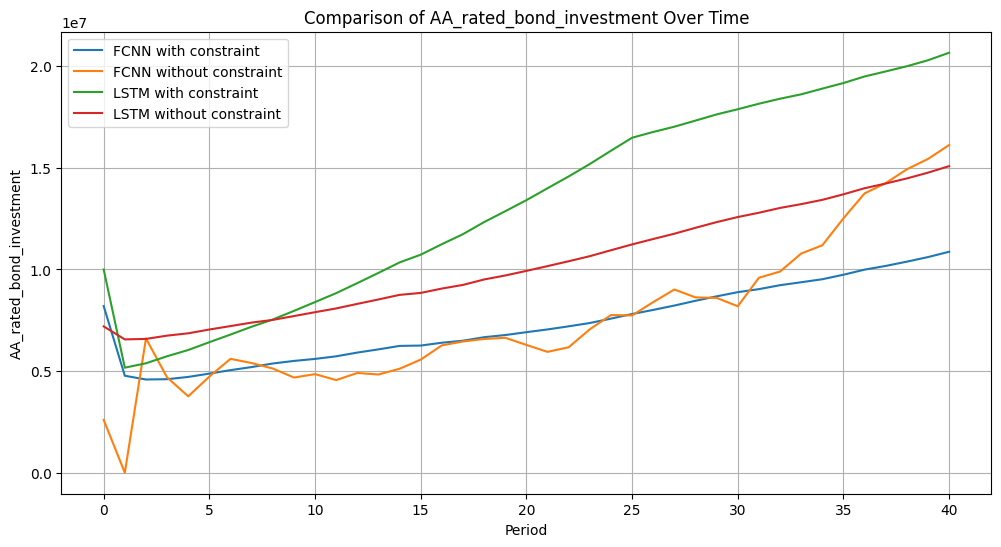

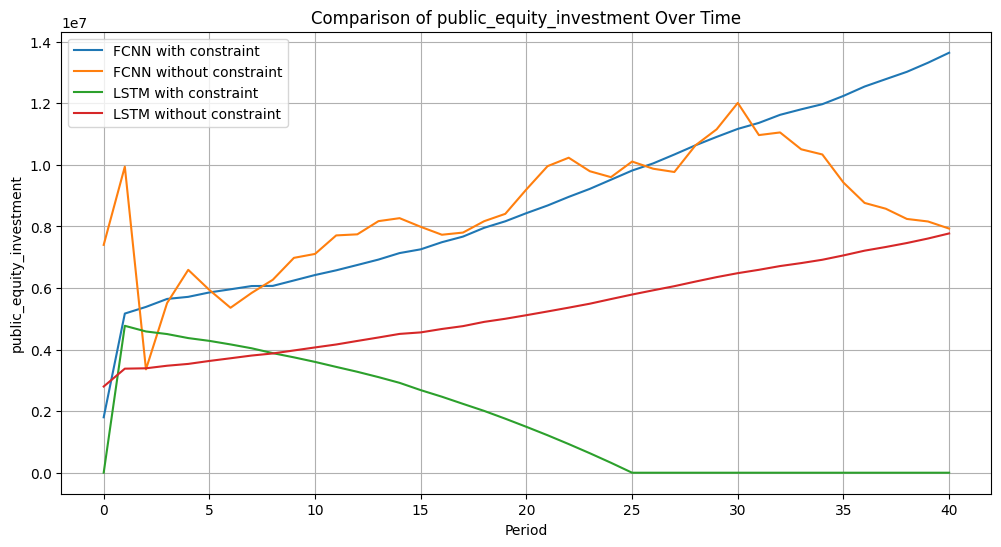

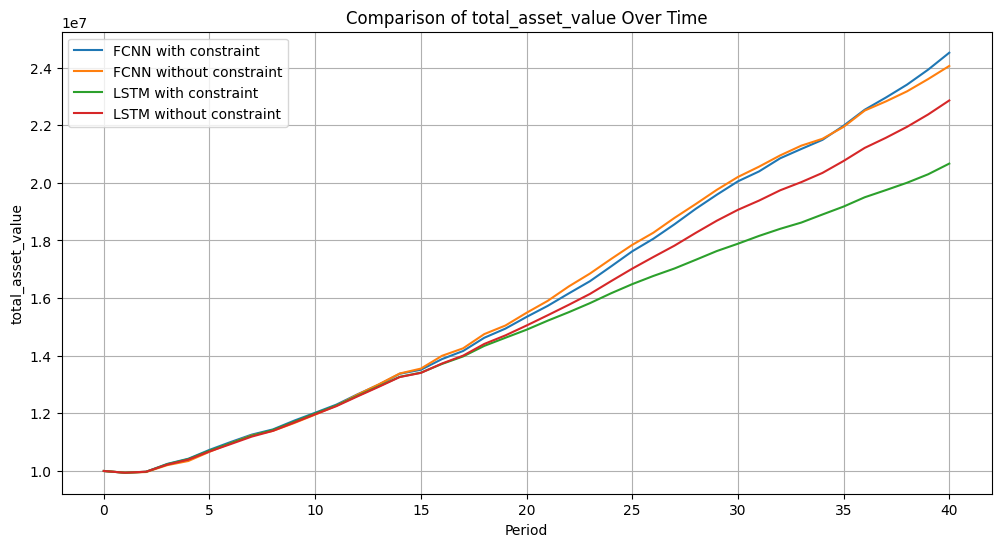

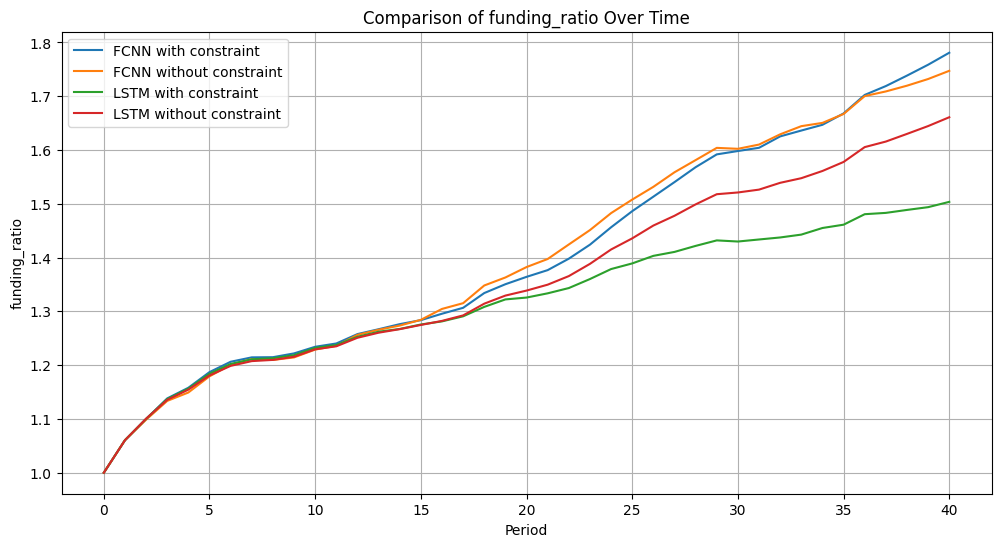

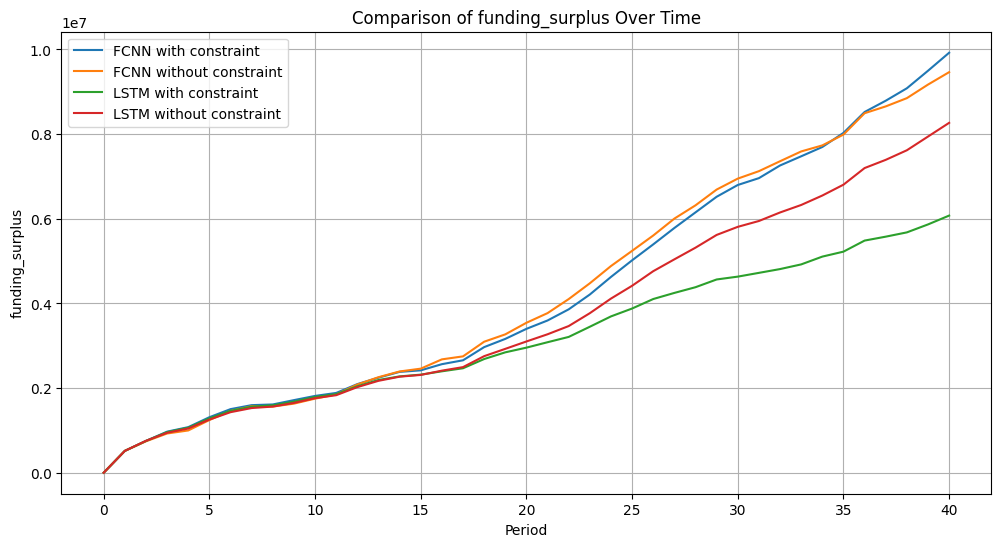

In [76]:
import matplotlib.pyplot as plt

def plot_model_comparison_mpl(column_name):
    # Create figure and axis
    plt.figure(figsize=(12, 6))
    
    # Plot lines for each model
    plt.plot(fcnn_w_constraint['period'].unique(), 
             fcnn_w_constraint.groupby('period')[column_name].mean(),
             label='FCNN with constraint')
    
    plt.plot(fcnn_wo_constraint['period'].unique(),
             fcnn_wo_constraint.groupby('period')[column_name].mean(), 
             label='FCNN without constraint')
    
    plt.plot(lstm_w_constraint['period'].unique(),
             lstm_w_constraint.groupby('period')[column_name].mean(),
             label='LSTM with constraint')
    
    plt.plot(lstm_wo_constraint['period'].unique(),
             lstm_wo_constraint.groupby('period')[column_name].mean(),
             label='LSTM without constraint')

    # Add labels and title
    plt.title(f'Comparison of {column_name} Over Time')
    plt.xlabel('Period')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)

    plt.show()
    plt.close()

for col in ['AA_rated_bond_investment','public_equity_investment','total_asset_value','funding_ratio','funding_surplus']:
    plot_model_comparison_mpl(col)
